In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import torch

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

# load the customized weight file
# model = torch.hub.load("ultralytics/yolov5", "custom", path = "./", force_reload = True)
# model.eval()
target_layers = [model.model.model.model[-5]]

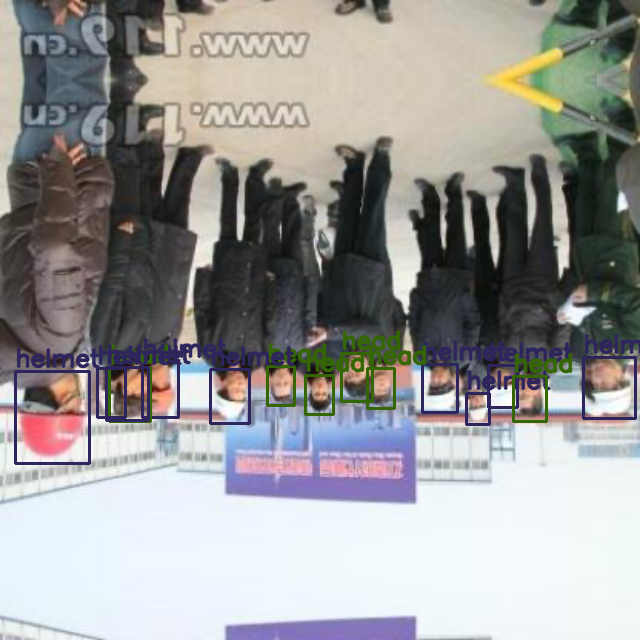

In [29]:
image_url = "./"
img = np.array(Image.open(image_url))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)
results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

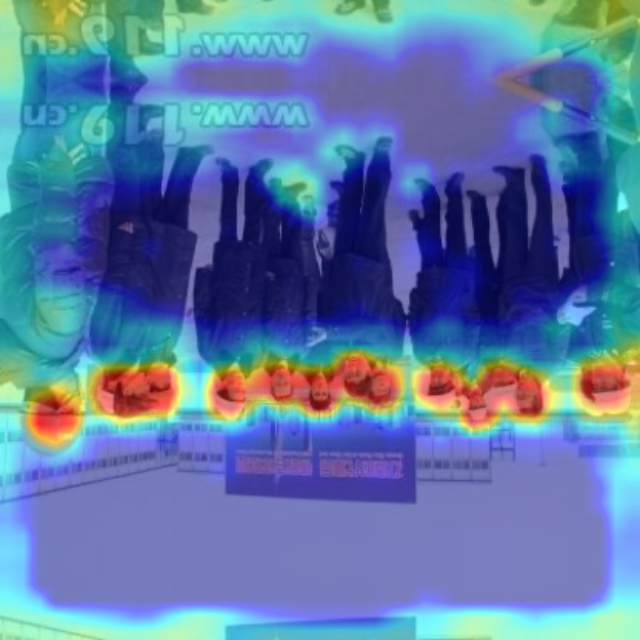

In [30]:
cam = EigenCAM(model, target_layers, use_cuda=True)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

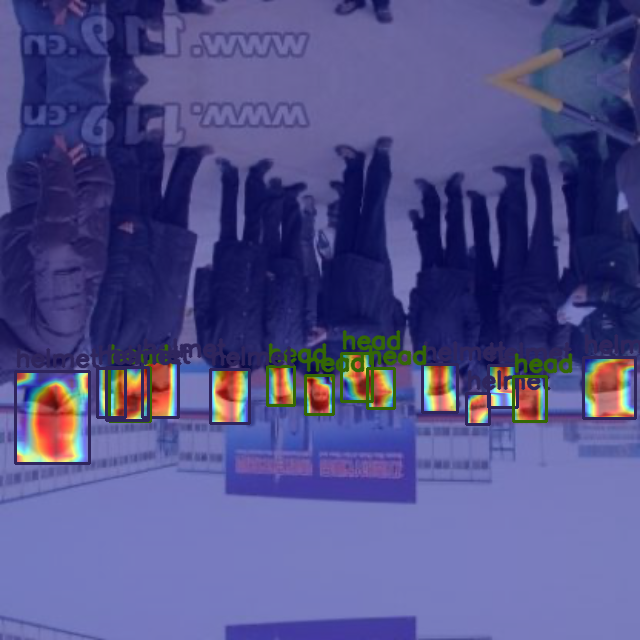

In [31]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

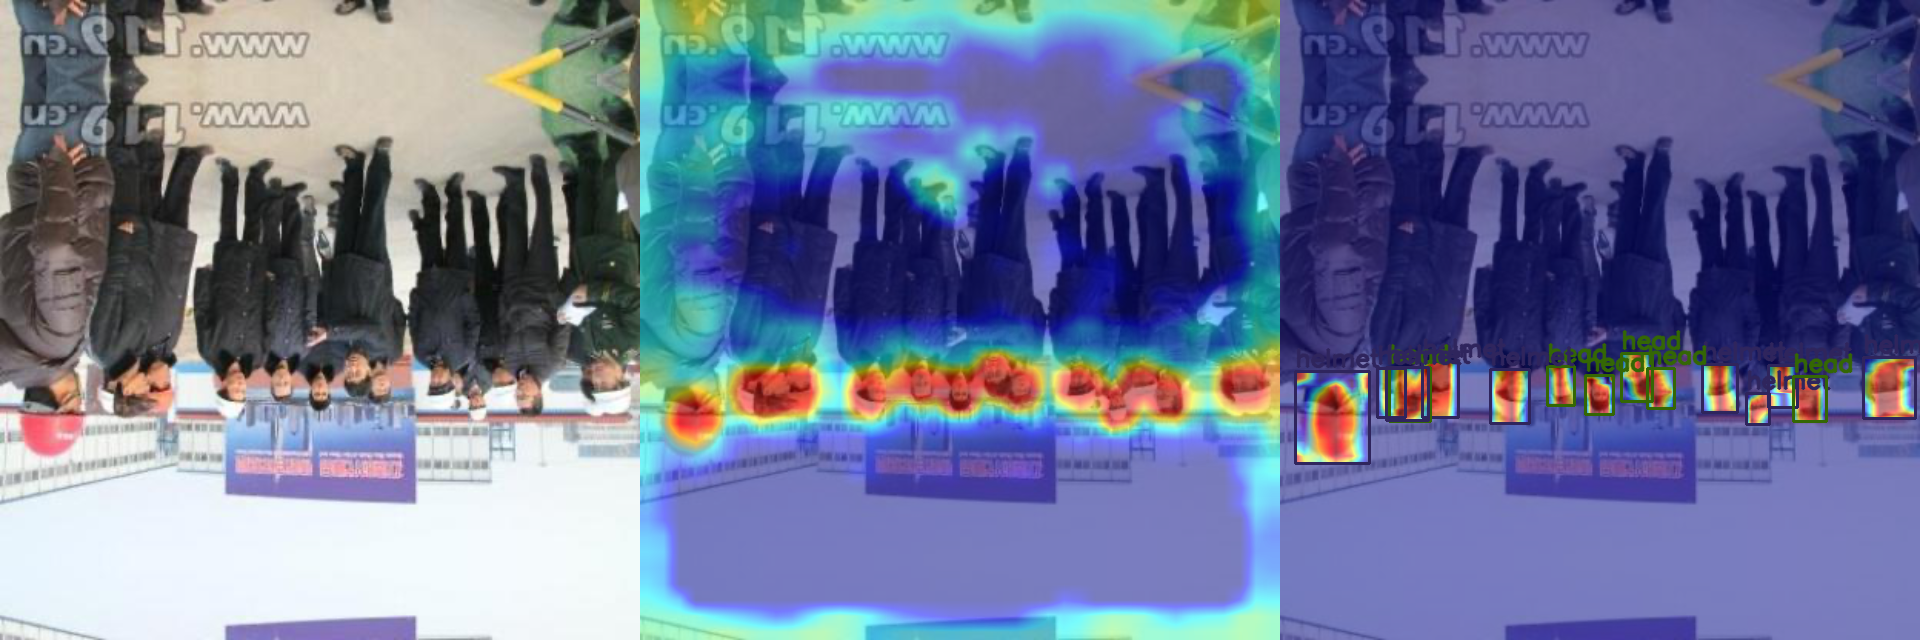

In [32]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))

In [ ]:
!nvidia-smi